In [ ]:
# Based on the initial Prompt we will predict whether the given question will take high conversations or Low conversations to resolve the issue.
#(For example if a question takes more than four prompts then we will assume that it will take more conversations to resolve the issue).

In [1]:
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from gensim import corpora, models
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mohit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# pip install --upgrade numpy
import warnings
warnings.filterwarnings("ignore")

In [4]:
file_path = "C:/Users/mohit/OneDrive/Desktop/DATASET.xlsx"
num_columns_to_read = len(pd.read_excel(file_path, nrows=1).columns)
df = pd.read_excel(file_path, usecols=range(num_columns_to_read))


# cleaning data
df['cleaned_text'] = df['Initial Prompt'].replace(r'\n', '', regex=True)
df['cleaned_text'] = df['Initial Prompt'].replace(r'<[^>]+>', '', regex=True) #html cleaning
df['cleaned_text'] = df['cleaned_text'].replace(r'http\S+', '', regex=True)
df['cleaned_text'] = df['cleaned_text'].replace(r'[^A-Za-z0-9\s]', '', regex=True)
df['cleaned_text'] = df['cleaned_text'].str.lower()

#removing stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_text(text):
    tokens = word_tokenize(str(text))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]
    return str(" ".join(tokens))

df['cleaned_text'] = df['cleaned_text'].apply(process_text)

# Display the first few rows of the processed data
df.head()

,Initial Prompt,Yes/No (Resolved or not),NumberOfPrompts,L/H (Low or High),Programming Language,which type of technology (DL/ML/WEB/None),cleaned_text
0,How to add a java class in a generic container...,Yes,3.0,L,Java,NaN,add java class generic container testcontainer...
1,How to run a java class inside of a container ...,Yes,2.0,L,Java,NaN,run java class inside container testcontainers
2,"I have a github repo on python, how to make it...",Yes,1.0,L,Python,NaN,github repo python make installable pip instal...
3,I'm using Terraform to manage some infrastruct...,Yes,2.0,L,HCL,NaN,im using terraform manage infrastructure gcp u...
4,I have a challenge for you. I'm working in a r...,No,8.0,H,TypeScript,WEB,challenge im working reacttypescript applicati...


In [5]:
print(df['L/H (Low or High)'].value_counts())
#Data processing
df['L/H (Low or High)']=df['L/H (Low or High)'].replace([':L','l'],'L')
print(df['L/H (Low or High)'].value_counts())
df['L/H (Low or High)']=df['L/H (Low or High)'].replace({'L':0,'H':1})
df['L/H (Low or High)']=df['L/H (Low or High)'].fillna(0)
print(df['L/H (Low or High)'].value_counts())


L/H (Low or High)
L     416
H     141
l       1
:L      1
Name: count, dtype: int64
L/H (Low or High)
L    418
H    141
Name: count, dtype: int64
L/H (Low or High)
0.0    481
1.0    141
Name: count, dtype: int64


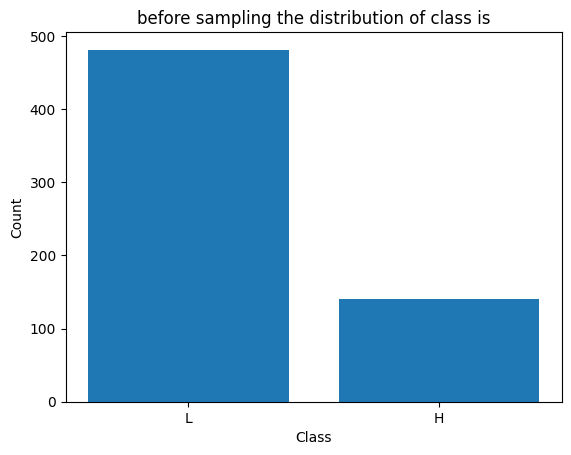

In [6]:
import matplotlib.pyplot as plt #
number= df['L/H (Low or High)'].value_counts()
plt.bar(['L','H'], number.values)

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('before sampling the distribution of class is')
plt.show()

In [7]:
from nltk import word_tokenize
data = df['cleaned_text'].map(word_tokenize).values

In [8]:
total_vocabulary = set(word.lower() for tweet in data for word in tweet)

In [9]:
print('There are {} unique words in the dataset.'.format(len(total_vocabulary)))
print('There are {} unique tweets in the dataset.'.format(len(data)))

There are 6421 unique words in the dataset.
There are 622 unique tweets in the dataset.


In [10]:
df['L/H (Low or High)']

0      0.0
1      0.0
2      0.0
3      0.0
4      1.0
      ... 
617    0.0
618    0.0
619    1.0
620    0.0
621    0.0
Name: L/H (Low or High), Length: 622, dtype: float64

The most repeated word is 'using' with a count of 157.


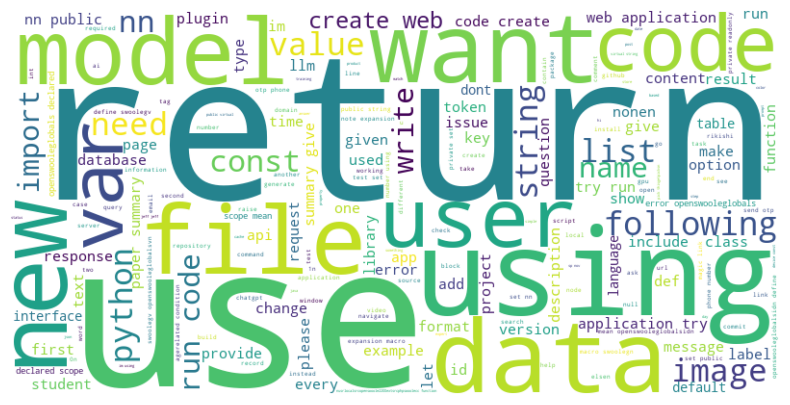

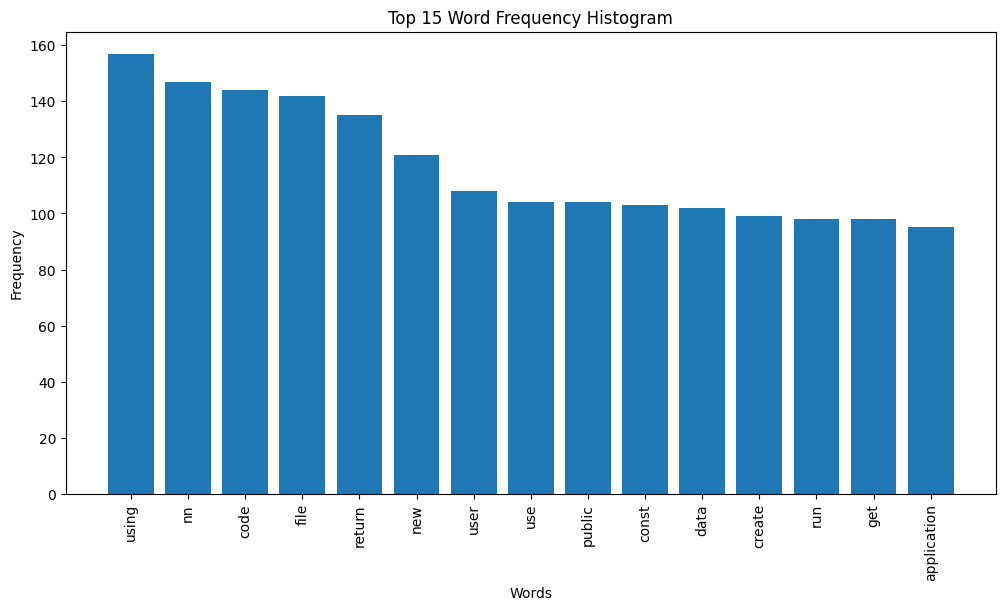

In [11]:
#finding most repeating word
def find_most_repeated_word(text):
    words = text.split()
    word_counts = Counter(words)
    most_repeated_word, count = word_counts.most_common(1)[0]
    return most_repeated_word, count

#generating word cloud
def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#generating histogram
def generate_histogram(text, top_n=15):
    words = text.split()
    word_counts = Counter(words)
    top_words, top_counts = zip(*word_counts.most_common(top_n))
    plt.figure(figsize=(12, 6))
    plt.bar(top_words, top_counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Word Frequency Histogram')
    plt.xticks(rotation=90)
    plt.show()


input_text = " ".join(df['cleaned_text'])

most_repeated_word, count = find_most_repeated_word(input_text)
print(f"The most repeated word is '{most_repeated_word}' with a count of {count}.")

generate_word_cloud(input_text)
generate_histogram(input_text)

In [13]:
#By using tf and idf vectorizing text data
def calculate_tf_idf(corpus):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    return tfidf_matrix.toarray()

def create_bag_of_words(corpus):
    count_vectorizer = CountVectorizer()
    bag_of_words = count_vectorizer.fit_transform(corpus)
    return bag_of_words

def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, sg=0):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, sg=sg)
    return model

In [14]:
#x_train_vectors = calculate_tf_idf(x_train['cleaned_text'])
#x_test_vectors = calculate_tf_idf(x_test['cleaned_text'])
vectors=calculate_tf_idf(df['cleaned_text'])


In [15]:
#Data sampaling to make data balance
from imblearn.over_sampling import SMOTE
over = SMOTE(sampling_strategy=0.4,random_state=32)
x_data_sampled,y_data_sampled=over.fit_resample(vectors,df['L/H (Low or High)'])
X_train, X_test, y_train, y_test = train_test_split(x_data_sampled,y_data_sampled, test_size=0.2, random_state=42)

In [20]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test_pad) # get our predictions
acc = accuracy_score(y_test, y_pred)
print('Overall accuracy of RNN: {:.3f}'.format(acc))

5/5 [==============================] - 0s 13ms/step
Overall accuracy of RNN: 0.704


In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from sklearn.metrics import classification_report
from bs4 import BeautifulSoup

In [22]:
tags_2 = list(set(df['L/H (Low or High)']))

In [23]:
#implementing knn model
from sklearn.neighbors import KNeighborsClassifier
tr_scores=[]
for i in range(1,40,2):
    knn=KNeighborsClassifier(n_neighbors=i)
    #simple cross validation
    knn.fit(X_train,y_train)
    pred=knn.predict(X_test)
    acc = accuracy_score(y_pred, y_test, normalize=True) * float(100)
    tr_scores.append(acc)
    print('\n accuracy for k = %d is %f%%' % (i, acc))


 accuracy for k = 1 is 70.370370%

 accuracy for k = 3 is 70.370370%

 accuracy for k = 5 is 70.370370%

 accuracy for k = 7 is 70.370370%

 accuracy for k = 9 is 70.370370%

 accuracy for k = 11 is 70.370370%

 accuracy for k = 13 is 70.370370%

 accuracy for k = 15 is 70.370370%

 accuracy for k = 17 is 70.370370%

 accuracy for k = 19 is 70.370370%

 accuracy for k = 21 is 70.370370%

 accuracy for k = 23 is 70.370370%

 accuracy for k = 25 is 70.370370%

 accuracy for k = 27 is 70.370370%

 accuracy for k = 29 is 70.370370%

 accuracy for k = 31 is 70.370370%

 accuracy for k = 33 is 70.370370%

 accuracy for k = 35 is 70.370370%

 accuracy for k = 37 is 70.370370%

 accuracy for k = 39 is 70.370370%


In [24]:
#implemented gridsearch to find best paranmeters
from sklearn.model_selection import GridSearchCV
k_range = list(range(1,40,2))
print(k_range)
param_grid = dict(n_neighbors=k_range)
print(param_grid)
cnn=KNeighborsClassifier(algorithm='brute')

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]
{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]}


In [25]:
# instantiate the grid
grid = GridSearchCV(cnn, param_grid, cv=10, scoring='accuracy', return_train_score=False)

In [26]:
# fit the grid with data
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(algorithm='brute'),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='accuracy')

In [27]:


# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)



0.710062893081761
{'n_neighbors': 1}
KNeighborsClassifier(algorithm='brute', n_neighbors=1)


In [28]:
cvk_scores=[]
knn = KNeighborsClassifier(1)
knn.fit(X_train,y_train)
predk = knn.predict(X_test)
acck = accuracy_score(y_pred, y_test, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acck))


****Test accuracy for k = 1 is 70%


In [29]:
from keras.models import Sequential

from keras.layers import LeakyReLU
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Assuming you have X_train, y_train, X_test, y_test as your data
# X_train, X_test, y_train, y_test
# Tokenization and vectorization
max_words = 6421
# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(X_train)
# X_train_seq = tokenizer.texts_to_sequences(X_train)
# X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = 100  # Sequence length
X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)

# RNN Model
model = Sequential()
model.add(Embedding(max_words,128, input_length=maxlen))

model.add(LSTM(128,return_sequences=False,
               dropout=0.1, recurrent_dropout=0.1))
# model.add(LeakyReLU(alpha=0.03))

model.add(Dense(10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
model.fit(X_train_pad, y_train, epochs=10, batch_size=10)

# Evaluation
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy}")

Epoch 1/10
54/54 [==============================] - 7s 74ms/step - loss: 0.0000e+00 - accuracy: 0.7063
Epoch 2/10
54/54 [==============================] - 4s 81ms/step - loss: 0.0000e+00 - accuracy: 0.7175
Epoch 3/10
54/54 [==============================] - 4s 70ms/step - loss: 0.0000e+00 - accuracy: 0.7175
Epoch 4/10
54/54 [==============================] - 4s 73ms/step - loss: 0.0000e+00 - accuracy: 0.7175
Epoch 5/10
54/54 [==============================] - 4s 71ms/step - loss: 0.0000e+00 - accuracy: 0.7175
Epoch 6/10
54/54 [==============================] - 4s 73ms/step - loss: 0.0000e+00 - accuracy: 0.7175
Epoch 7/10
54/54 [==============================] - 4s 75ms/step - loss: 0.0000e+00 - accuracy: 0.7175
Epoch 8/10
54/54 [==============================] - 4s 71ms/step - loss: 0.0000e+00 - accuracy: 0.7175
Epoch 9/10
54/54 [==============================] - 4s 74ms/step - loss: 0.0000e+00 - accuracy: 0.7175
Epoch 10/10
5/5 [==============================] - 0s 16ms/step - loss: 0

In [30]:
text="wrong without disclosing the correct answer in the explanations of the wrong options"
text_ = calculate_tf_idf([text])
text_ = pad_sequences(text_,maxlen=maxlen)
pred = model.predict(text_)
# pred_= model.predict_proba(text_)
import numpy as np

classes_x=np.argmax(pred,axis=1)
# m2= model.predict_proba(mytest)

1/1 [==============================] - 0s 208ms/step


In [31]:
classes_x

array([0], dtype=int64)